# Sequential image reconstruction

Image reconstruction.

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy as np
import torch
from torch import nn

import swyft
from swyft.utils.ns import SwyftSimpleSliceSampler
from swyft.lightning.estimators import LogRatioEstimator_Autoregressive, LogRatioEstimator_Gaussian, LogRatioEstimator_Autoregressive_Gaussian

import pylab as plt

#import pytorch_lightning as pl

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

In [33]:
Npix = 32
N = Npix**2
print(N)

l = torch.arange(Npix)
L1, L2 = torch.meshgrid(l, l)
L = torch.stack([L1, L2], dim = -1)
T = L.unsqueeze(0).unsqueeze(0) - L.unsqueeze(2).unsqueeze(2)
T = (T**2).sum(-1)**0.5
T = T.view(N, N)
Cov = torch.exp(-T/16)*0.5 + torch.exp(-T/8)*.25 + torch.exp(-T/4)*.125

dist = torch.distributions.MultivariateNormal(torch.zeros(N), Cov)

1024


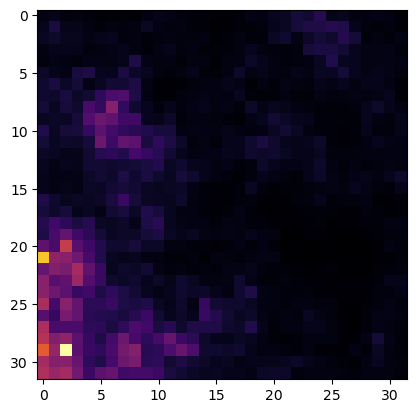

In [34]:
def sample_GP(N, gamma = 3):
    #z = np.random.multivariate_normal(np.zeros(N), Cov.numpy()).reshape(Npix, Npix)
    z = dist.sample(torch.Size([1]))[0].numpy().reshape(Npix, Npix)
    return z

z = sample_GP(N, gamma = 2.5)
plt.imshow(np.exp(z), cmap='inferno')

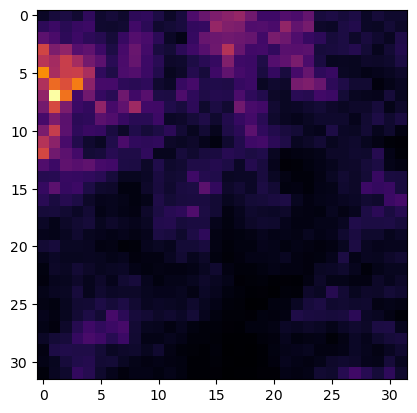

In [35]:
class Sim(swyft.Simulator):
    def __init__(self, sigma = .01, bounds = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.sigma = sigma
        self.bounds = bounds

    def sample_GP(self):
        if self.bounds is None:
            return sample_GP(N, gamma = 2.5)
        else:
            i = np.random.randint(len(self.bounds))
            return self.bounds[i]

    def build(self, graph):
        z = graph.node("z", lambda: self.sample_GP())
        y = graph.node("y", lambda z: np.exp(z), z)
        x = graph.node("x", lambda y: y + np.random.randn(Npix, Npix)*self.sigma, y)

sim = Sim()
s = sim.sample()
plt.imshow(s['x'], cmap='inferno')

In [36]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, D = 100):
        super().__init__()

        self.optimizer_init = swyft.AdamOptimizerInit(lr=2e-4, lrs_factor=0.1, lrs_patience=3)
        self.num_params = D
        self.lre = LogRatioEstimator_Autoregressive_Gaussian(D, "mu")
#        self.l = nn.Sequential(
#            nn.LazyLinear(128),
#            nn.ReLU(),
#            nn.LazyLinear(128),
#            nn.ReLU(),
#            nn.LazyLinear(1)
#        )
        self.l = lambda x: torch.log(torch.abs(x)+1e-3)

    def forward(self, A, B):
        x = A["x"].view(-1, N)
        f = self.l(x.unsqueeze(-1)).squeeze(-1)
       # print(f.shape)
        #qwerty
        f += torch.randn_like(f)*1e-3
        result = self.lre(f, A['z'].view(-1,N), B['z'].view(-1, N))
        return result

In [37]:
samples = sim.sample(1000)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
net = Network(D=N)

In [39]:
net.lre._momentum = 0.02

In [40]:
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 50)
trainer.fit(net, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                      | Params
-------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Autoregressive_Gaussian | 2.1 M 
-------------------------------------------------------------------
1.0 M     Trainable params
1.0 M     Non-trainable params
2.1 M     Total params
8.389     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

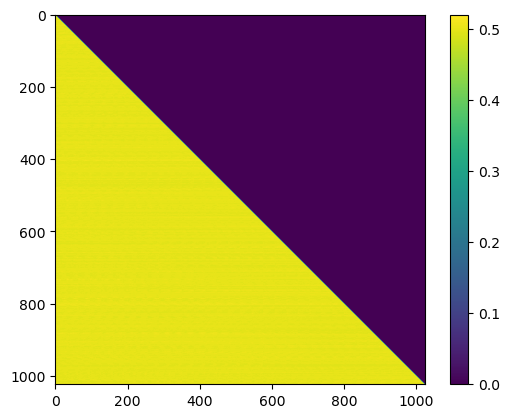

In [41]:
Phi = net.lre.Phi.detach().cpu().numpy()
plt.imshow(Phi)
plt.colorbar()

In [42]:
B = net.lre.B.weight.detach().cpu().numpy()
plt.imshow(B)
plt.colorbar()


KeyboardInterrupt



In [ ]:
i = np.random.randint(len(samples))
print(i)
sample0 = samples[i]

In [ ]:
Cov = Cov.double().cuda()
x = torch.tensor(sample0['x']).view(-1, N)
y = torch.tensor(sample0['y']).view(-1, N)
net.cuda()
f = net.l(torch.tensor(x).cuda().unsqueeze(-1)).squeeze(-1).detach()[0]

#print(f.shape)
draws = net.lre.get_samples(10000, f, cov = Cov*1, gamma = 0.25).view(-1, Npix, Npix).cpu()

plt.figure(figsize=(20, 5))
plt.subplot(1,5,1)
plt.imshow(x.view(Npix,Npix), cmap='inferno')
plt.subplot(1,5,2)
plt.imshow(y.view(Npix,Npix), cmap='inferno')
for i in range(3):
    plt.subplot(1, 5, i+3)
    plt.imshow(np.exp(draws[i].cpu()), cmap='inferno')

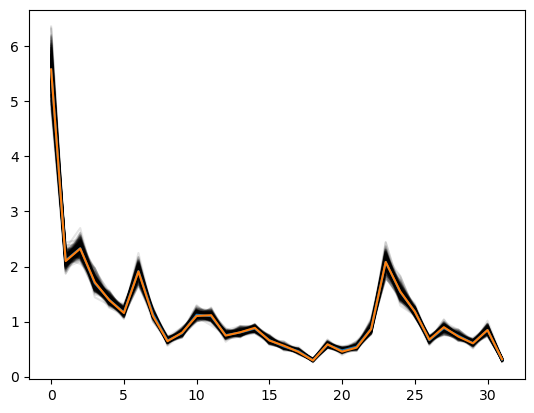

In [43]:
j = 20
for i in range(300):
    plt.plot(np.exp(draws[i].cpu())[:,j], 'k', alpha = 0.1)
plt.plot(x.view(Npix,Npix)[:,j])
plt.plot(y.view(Npix,Npix)[:,j])

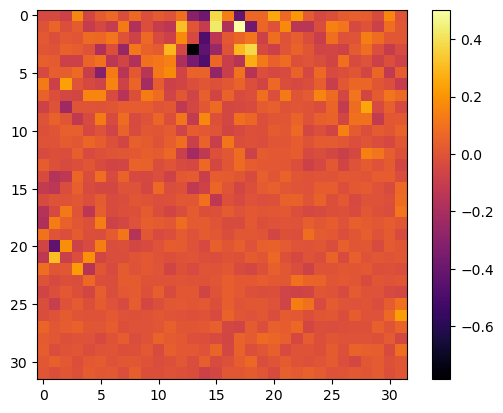

In [30]:
sim = Sim(bounds = draws)
s = sim.sample()
plt.imshow(s['x']-y.view(Npix,Npix).numpy(), cmap='inferno')
plt.colorbar()